# Import libraries and modules

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

In [2]:
import sys, os
# add project root (parent folder of the notebook) to sys.path
sys.path.append(os.path.abspath(".."))

from causalDA.data_generation import DataGenerator
from causalDA.plotting import plot_graph, plot_links_graph_svg
from reproduce.utils.config import ACTIVITY_NAME, BASE_RANGE, EDGE_PROB, INFLUENCE_FROM_PARENTS, NODE_LOOKUP, TARGET_NODE, TIME_PERIODS, sample_conversion_dict

from matplotlib import pyplot as plt
import pandas as pd

import re
import networkx as nx
import numpy as np
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import random

from dowhy import gcm
from causalDA.model import CausalModel

from reproduce.utils.helpers import snake_case, convert_effect_dict_to_links_dict, snake_case_dict

from tqdm import tqdm
from IPython.display import SVG, display, HTML

# Gernerate synthetic data

## Configuration

# Generating Synthetic Causal Data

This guide walks you through generating synthetic time series data from a random DAG (Directed Acyclic Graph) using a custom `DataGenerator`
---

Information:

* We begin by creating an instance of `DataGenerator`, seeding the random number generator to ensure reproducibility.
* We simulate a random DAG based on a specified edge probability. Please refer to `utils/config` to change the parameters
* We create a dictionary `conversion_dict` that maps nodes to their conversion effectiveness.
* This `dag_result` will be a nested dictionary with relationships and weights that were used to generate the data — useful for interpretability or validation.

In [3]:
seed = 123
gen = DataGenerator(
    node_lookup=NODE_LOOKUP,
    name_activity=ACTIVITY_NAME,
    target_node=TARGET_NODE,
    seed=seed,
)

graph = gen.generate_random_dag(edge_prob=EDGE_PROB)

conversion_dict = sample_conversion_dict()

df, dict_contributions, effect_dict = gen.generate_data(
    influence_from_parents=INFLUENCE_FROM_PARENTS,
    conversion_dict=conversion_dict,
    time_periods=TIME_PERIODS,
    base_range=BASE_RANGE,
    carryover=False,
)
df.columns = [snake_case(col) for col in df.columns]

dag_result = gen.get_causal_graph()

In [4]:
df.head()

,google_ads_impression,youtube_impression,affiliates_impression,facebook_impression,tiktok_impression,facebook_conversion,google_ads_conversion,tiktok_conversion,youtube_conversion,affiliates_conversion,conversion,baseline
0,1518.263849,1709.374050,1085.321183,1459.276242,2698.931463,161.750054,196.911412,410.596438,166.852492,63.353072,1099.095961,99.632493
1,1332.505410,1961.426390,1891.474412,1673.070631,3046.119551,185.447591,172.819449,463.415191,191.455393,110.410371,1224.804781,101.256786
2,1041.775650,1444.816240,2017.994349,1594.025167,2481.447971,176.685982,135.113218,377.510031,141.028928,117.795675,1052.193048,104.059215
3,1546.162174,1203.967461,1126.793316,1029.553906,2548.846176,114.118489,200.529689,387.763519,117.519610,65.773910,982.076457,96.371240
4,1769.675504,992.394205,1803.076276,1546.404967,2692.589615,171.407633,229.518277,409.631634,96.867883,105.250338,1116.320303,103.644538


## Dataframe

In [5]:
all_channels = [snake_case(ch) + '_' + ACTIVITY_NAME for ch in NODE_LOOKUP.values() if ch != TARGET_NODE]
target_node = snake_case(TARGET_NODE)
data = df[[target_node] + all_channels]
data

,conversion,facebook_impression,google_ads_impression,tiktok_impression,youtube_impression,affiliates_impression
0,1099.095961,1459.276242,1518.263849,2698.931463,1709.374050,1085.321183
1,1224.804781,1673.070631,1332.505410,3046.119551,1961.426390,1891.474412
2,1052.193048,1594.025167,1041.775650,2481.447971,1444.816240,2017.994349
3,982.076457,1029.553906,1546.162174,2548.846176,1203.967461,1126.793316
4,1116.320303,1546.404967,1769.675504,2692.589615,992.394205,1803.076276
...,...,...,...,...,...,...
360,1162.784263,1526.979298,1711.877175,2639.437090,1638.226303,2015.643092
361,1054.515028,1379.918199,1143.698423,2632.752746,1575.298340,1742.837056
362,971.912344,1068.678005,1237.236528,2502.107904,1187.734575,1647.525738
363,1173.926341,1460.651850,1729.127311,2902.981154,1783.782493,1084.055520


### Export Data

In [6]:
if not os.path.exists('data'):
    os.makedirs('data')
data.to_csv(f'data/synthetic_data_seed_{seed}.csv', index=False)

## Causal Graph

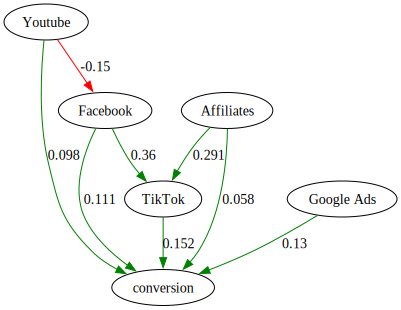

In [7]:
links_dict = convert_effect_dict_to_links_dict(effect_dict)
plot_links_graph_svg(links_dict, show_value=True, rounding=3, show_legend=False)


In [8]:
links_dict

{'Facebook': {'Youtube': {'value': -0.14994805535675007, 'lag': 0}},
 'TikTok': {'Facebook': {'value': 0.360076675695398, 'lag': 0},
  'Affiliates': {'value': 0.2911153052145223, 'lag': 0}},
 'conversion': {'Facebook': {'value': 0.11084265531555806, 'lag': 0},
  'Google Ads': {'value': 0.12969511998370117, 'lag': 0},
  'TikTok': {'value': 0.15213296229931655, 'lag': 0},
  'Youtube': {'value': 0.09761028712256305, 'lag': 0},
  'Affiliates': {'value': 0.058372648456358436, 'lag': 0}}}

## Visualisation

In [9]:
all_channels

['facebook_impression',
 'google_ads_impression',
 'tiktok_impression',
 'youtube_impression',
 'affiliates_impression']

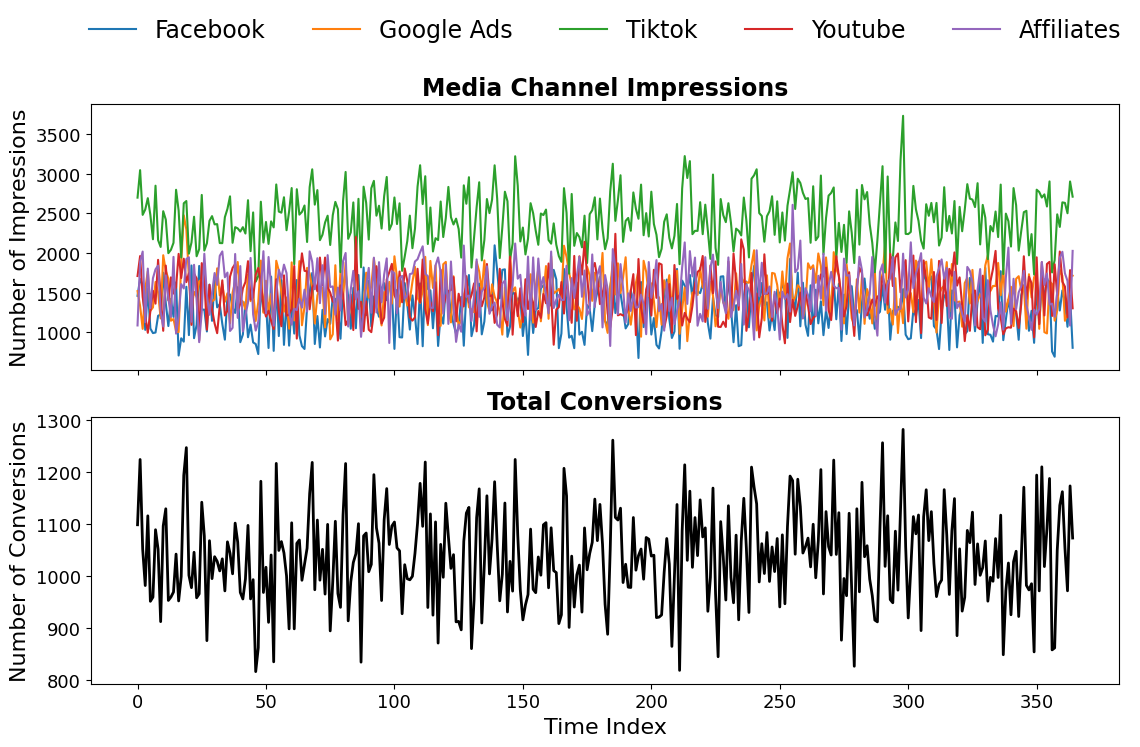

In [24]:
# Create two vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Plot 1: Media Channels ---
for channel in all_channels:
    axes[0].plot(
        df.index,
        df[channel],
        label=channel.replace("_impression", "").replace("_", " ").title()
    )

axes[0].set_title("Media Channel Impressions", fontsize=17, fontweight="bold")
axes[0].set_ylabel("Number of Impressions", fontsize=16)

# Move legend to top, in one line
axes[0].legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=len(all_channels),
    frameon=False,
    fontsize=17
)

axes[0].tick_params(axis="both", labelsize=13)

# --- Plot 2: Conversion ---
axes[1].plot(df.index, df["conversion"], color="black", linewidth=2)
axes[1].set_title("Total Conversions", fontsize=17, fontweight="bold")
axes[1].set_xlabel("Time Index", fontsize=16)
axes[1].set_ylabel("Number of Conversions", fontsize=16)
axes[1].tick_params(axis="both", labelsize=13)

# Adjust layout to leave room for top legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Causal-Driven Attribution

## Causal Discovery - PCMCI (Tigramite)

In [78]:
tau = 30

# Assume df is your synthetic dataset
selected_columns = all_channels + [target_node]

model = CausalModel(data, selected_columns, verbose=1)
results = model.run_pcmci(tau_max=tau, pc_alpha=0.2, alpha_level=0.05)

lagged_links = model.get_lagged_links(alpha_level=0.05, drop_source=target_node)
dag_links = model.prune_bidirectional_links(lagged_links)


pruned_dag = model.prune_cycles(dag_links, priority_node=target_node, verbose=False)

### Visualisation

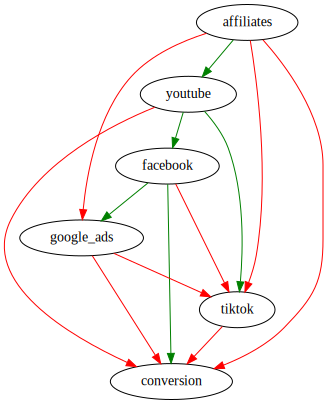

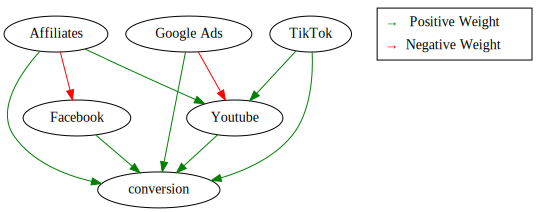

In [9]:
svg_prediction  = plot_links_graph_svg(pruned_dag, show_value=False, show_legend=False)
svg_groundtruth = plot_links_graph_svg(links_dict, show_value=False, show_legend=True)

# Wrap with titles and layout
html = f"""
<div style="display: flex; flex-direction: row; gap: 40px; align-items: flex-start; flex-wrap: nowrap;">
    <div style="text-align: center; width: 48%;">
        <h3>Predicted DAG</h3>
        {svg_prediction}
    </div>
    <div style="text-align: center; width: 48%;">
        <h3>Ground Truth DAG</h3>
        {svg_groundtruth}
    </div>
</div>
"""
display(HTML(html))


In [10]:
def build_causal_digraph(dag_result, extra_nodes=None, extra_edges=None):
    edges = []
    nodes = set()

    for effect, causes in dag_result.items():
        nodes.add(effect)
        for cause in causes:
            nodes.add(cause)
            edges.append(f'    {cause} -> {effect}')

    if extra_nodes:
        for node in extra_nodes:
            node = snake_case(node)
            nodes.add(node)

    if extra_edges:
        for src, dst in extra_edges:
            src = snake_case(src)
            dst = snake_case(dst)
            nodes.add(src)
            nodes.add(dst)
            edges.append(f'    {src} -> {dst}')

    # Build Graphviz digraph
    node_lines = [f'    {node}' for node in sorted(nodes)]
    graph = 'digraph {\n' + '\n'.join(node_lines + edges) + '\n}'
    return graph


In [11]:
model_causal_graph = build_causal_digraph(pruned_dag)
true_dag = snake_case_dict(links_dict)
true_causal_graph = build_causal_digraph(true_dag)

## Incremental causal attribution

In [40]:
def estimate_conversion_drop_via_sampling_repeated(
    scm,
    data: pd.DataFrame,
    channel: str,
    target: str = "conversion",
    n_runs: int = 5000
) -> float:
    drops = []
    for _ in range(n_runs):
        baseline = gcm.interventional_samples(scm, {}, observed_data=data)
        after_do = gcm.interventional_samples(scm, {channel: lambda x: 0.0}, observed_data=data)
        drop = baseline[target].mean() - after_do[target].mean()
        drops.append(drop)
    return float(np.mean(drops))

In [41]:
def calculate_causal_effect_per_unit(conversion_drop: float, channel_series: pd.Series) -> float:
    mean_input = channel_series.mean()
    if mean_input == 0:
        raise ValueError("Mean of channel is zero; can't divide by zero.")
    return conversion_drop / mean_input

### Using Ground Truth

In [42]:
# Extract edges using regex
edges = re.findall(r'(\w+)\s*->\s*(\w+)', true_causal_graph)

# Create the DiGraph
converted_causal_graph = nx.DiGraph(edges)

In [43]:
# Create the structural causal model object
scm_true = gcm.StructuralCausalModel(converted_causal_graph)

In [44]:
# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm_true, data)

In [45]:
gcm.fit(scm_true, data)

Fitting causal mechanism of node conversion: 100%|██████████| 6/6 [00:00<00:00, 505.99it/s]


In [46]:
true_ACE_result = {} # Average Causal Effect

for source in all_channels:
    channel_drop = estimate_conversion_drop_via_sampling_repeated(scm_true, data, source, target = target_node, n_runs = 5000)
    channel_mean = data[source].mean()
    causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
    true_ACE_result[source] = {
        "conversion_drop": channel_drop,
        "ace": causal_effect
    }
true_ACE_result

{'facebook': {'conversion_drop': 162.37911736361343,
  'ace': 0.11788433409430686},
 'google_ads': {'conversion_drop': 121.97494457040436,
  'ace': 0.08146188241916795},
 'tiktok': {'conversion_drop': 324.4092399040594, 'ace': 0.21514626850750812},
 'youtube': {'conversion_drop': 324.62914452133896,
  'ace': 0.12405628315938254},
 'affiliates': {'conversion_drop': 209.59995710524703,
  'ace': 0.14027304433034515}}

### Example - Ground Truth

In [47]:
source = "facebook"
channel_drop = estimate_conversion_drop_via_sampling_repeated(scm_true, data, source, target = target_node, n_runs = 5000)
print(f"Estimated drop on {target_node} if {source} is turned off: {channel_drop:.2f}")

channel_mean = data[source].mean()

causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
print(f"Causal effect of {source} per unit: {causal_effect:.4f} conversions per unit increase")


Estimated drop on conversion if facebook is turned off: 162.38
Causal effect of facebook per unit: 0.1179 conversions per unit increase


### Using Model

In [48]:
# Extract edges using regex
edges = re.findall(r'(\w+)\s*->\s*(\w+)', model_causal_graph)

# Create the DiGraph
converted_causal_graph = nx.DiGraph(edges)

In [49]:
# Create the structural causal model object
scm_model = gcm.StructuralCausalModel(converted_causal_graph)

In [50]:
# Automatically assign generative models to each node based on the given data
gcm.auto.assign_causal_mechanisms(scm_model, data)

In [51]:
gcm.fit(scm_model, data)

Fitting causal mechanism of node conversion: 100%|██████████| 6/6 [00:00<00:00, 374.58it/s]


In [52]:
model_ACE_result = {} # Average Causal Effect

for source in all_channels:
    channel_drop = estimate_conversion_drop_via_sampling_repeated(scm_model, data, source, target = target_node, n_runs = 5000)
    channel_mean = data[source].mean()
    causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
    model_ACE_result[source] = {
        "conversion_drop": channel_drop,
        "ace": causal_effect
    }
model_ACE_result

{'facebook': {'conversion_drop': 178.43112330810632,
  'ace': 0.12953780322486658},
 'google_ads': {'conversion_drop': 157.72140724003177,
  'ace': 0.10533542586819622},
 'tiktok': {'conversion_drop': 254.89344009223225, 'ace': 0.1690438056545615},
 'youtube': {'conversion_drop': 458.33976001479476,
  'ace': 0.17515348825330507},
 'affiliates': {'conversion_drop': 181.57127417215506,
  'ace': 0.12151507921482474}}

In [53]:
source = "facebook"
channel_drop = estimate_conversion_drop_via_sampling_repeated(scm_model, data, source, target = target_node, n_runs = 5000)
print(f"Estimated drop on {target_node} if {source} is turned off: {channel_drop:.2f}")

channel_mean = data[source].mean()

causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
print(f"Causal effect of {source} per unit: {causal_effect:.4f} conversions per unit increase")


Estimated drop on conversion if facebook is turned off: 178.42
Causal effect of facebook per unit: 0.1295 conversions per unit increase


# Evaluation

## Ground Truth

In [54]:
def compute_causal_effects(links_dict, outcome='conversion'):
    """
    Computes direct and total causal effects from a DAG links_dict to a specified outcome variable.

    Args:
        links_dict (dict): DAG in the format {target: {source: {'value': weight, 'lag': int}}}
        outcome (str): Name of the outcome node (default: 'conversion')

    Returns:
        dict: direct_effects
        dict: total_effects
    """

    # Direct effects: only edges pointing to the outcome node
    direct_effect = {
        src: data['value']
        for src, data in links_dict.get(outcome, {}).items()
    }

    # Build adjacency list: source -> list of (target, weight)
    edges = defaultdict(list)
    for target, parents in links_dict.items():
        for parent, data in parents.items():
            edges[parent].append((target, data['value']))

    # Recursive function to find all weighted paths from node to outcome
    def get_paths_to_outcome(node, visited=None, cumulative=1.0):
        if visited is None:
            visited = set()
        if node in visited:
            return []
        visited.add(node)
        paths = []
        for child, weight in edges[node]:
            new_cumulative = cumulative * weight
            if child == outcome:
                paths.append(new_cumulative)
            else:
                paths += get_paths_to_outcome(child, visited.copy(), new_cumulative)
        return paths

    # Total effects: sum of all path weights to the outcome
    total_effect = {}
    for node in edges.keys():
        paths = get_paths_to_outcome(node)
        if paths:
            total_effect[node] = sum(paths)

    return direct_effect, total_effect


In [55]:
direct_effect, total_effect = compute_causal_effects(links_dict)
print("Direct:", direct_effect)
print("Total:", total_effect)

Direct: {'Facebook': 0.1181565812704725, 'Google Ads': 0.10003893829205072, 'TikTok': 0.16922115592912176, 'Youtube': 0.12322370567394016, 'Affiliates': 0.1111653160488281}
Total: {'Affiliates': 0.16119500549925309, 'Google Ads': 0.08238431167618257, 'TikTok': 0.2161454831837214, 'Facebook': 0.1181565812704725, 'Youtube': 0.12322370567394016}


## Causal Effect (Total Effect)

### Estimation

#### Ground Truth

In [56]:
# Compute RMSE
# Normalize direct_effect keys
normalized_total = {snake_case(k): v for k, v in total_effect.items()}

# Align keys
common_keys = list(set(normalized_total.keys()) & set(true_ACE_result.keys()))
total_vals = [normalized_total[k] for k in common_keys]
ace_vals = [true_ACE_result[k]['ace'] for k in common_keys]

# Compute RMSE
rmse = np.sqrt(mean_squared_error(ace_vals, total_vals))
print(f"RMSE between Total Effect and ACE: {rmse:.5f}")

relative_rmse = rmse / np.mean(ace_vals)
print(f"Relative RMSE: {relative_rmse:.2%}")

RMSE between Total Effect and ACE: 0.00938
Relative RMSE: 6.91%


#### Model

In [57]:
# Compute RMSE
# Normalize direct_effect keys
normalized_total = {snake_case(k): v for k, v in total_effect.items()}

# Align keys
common_keys = list(set(normalized_total.keys()) & set(model_ACE_result.keys()))
total_vals = [normalized_total[k] for k in common_keys]
ace_vals = [model_ACE_result[k]['ace'] for k in common_keys]

# Compute RMSE
rmse = np.sqrt(mean_squared_error(ace_vals, total_vals))
print(f"RMSE between Total Effect and ACE: {rmse:.5f}")

relative_rmse = rmse / np.mean(ace_vals)
print(f"Relative RMSE: {relative_rmse:.2%}")

RMSE between Total Effect and ACE: 0.03780
Relative RMSE: 26.98%


### Visualisation

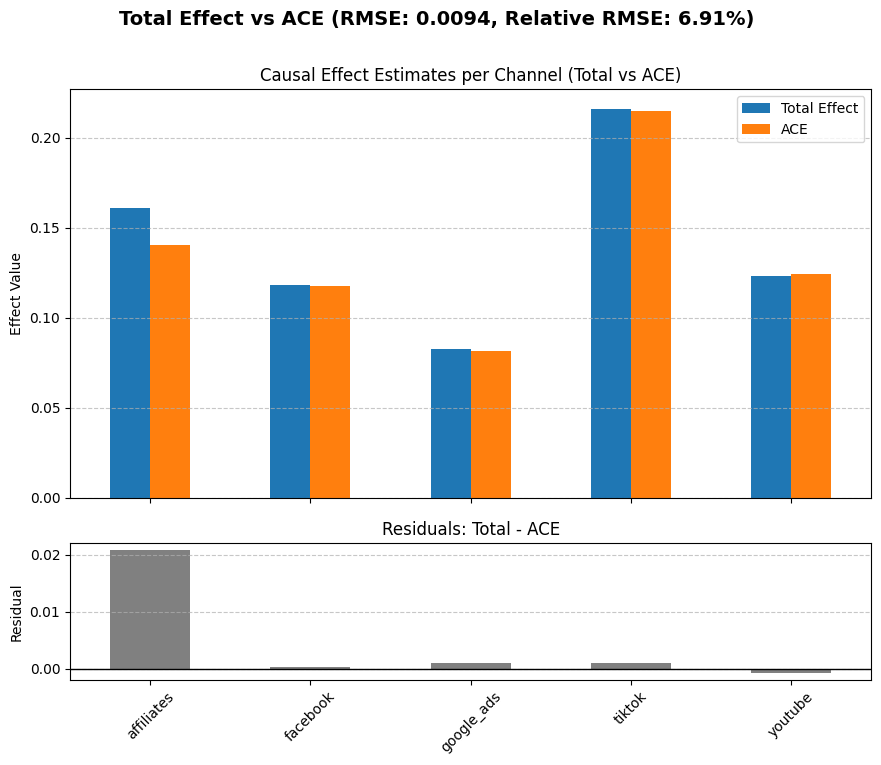

In [ ]:
# Prepare DataFrame
normalized_ace = {k: v['ace'] for k, v in true_ACE_result.items()}
df = pd.DataFrame({
    'Total Effect': pd.Series(normalized_total),
    'ACE': pd.Series(normalized_ace)
})
df['Residual (Total - ACE)'] = df['Total Effect'] - df['ACE']
df = df.sort_index()

# Compute RMSE
ace_vals = df['ACE'].values
total_vals = df['Total Effect'].values
rmse = np.sqrt(mean_squared_error(ace_vals, total_vals))
relative_rmse = rmse / np.mean(ace_vals)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Title with RMSE
fig.suptitle(
    f"Ground Truth - Total Effect vs ACE (RMSE: {rmse:.4f}, Relative RMSE: {relative_rmse:.2%})",
    fontsize=14,
    fontweight='bold',
    y=0.95
)

# Top bar plot
df[['Total Effect', 'ACE']].plot(kind='bar', ax=ax[0])
ax[0].set_ylabel('Effect Value')
ax[0].set_title('Causal Effect Estimates per Channel (Total vs ACE)', fontsize=12)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Residuals bar plot
df['Residual (Total - ACE)'].plot(kind='bar', ax=ax[1], color='gray')
ax[1].axhline(0, color='black', linewidth=1)
ax[1].set_ylabel('Residual')
ax[1].set_title('Residuals: Total - ACE', fontsize=12)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.94])  # leave space for suptitle
plt.show()

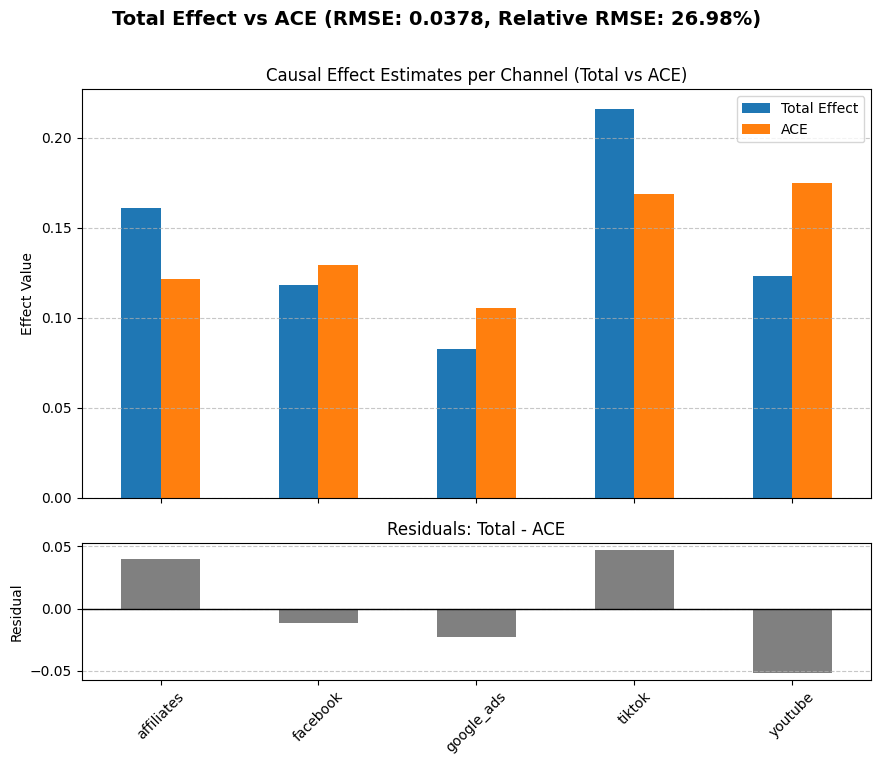

In [ ]:
# Prepare DataFrame
normalized_ace = {k: v['ace'] for k, v in model_ACE_result.items()}
df = pd.DataFrame({
    'Total Effect': pd.Series(normalized_total),
    'ACE': pd.Series(normalized_ace)
})
df['Residual (Total - ACE)'] = df['Total Effect'] - df['ACE']
df = df.sort_index()

# Compute RMSE
ace_vals = df['ACE'].values
total_vals = df['Total Effect'].values
rmse = np.sqrt(mean_squared_error(ace_vals, total_vals))
relative_rmse = rmse / np.mean(ace_vals)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Title with RMSE
fig.suptitle(
    f"Model - Total Effect vs ACE (RMSE: {rmse:.4f}, Relative RMSE: {relative_rmse:.2%})",
    fontsize=14,
    fontweight='bold',
    y=0.95
)

# Top bar plot
df[['Total Effect', 'ACE']].plot(kind='bar', ax=ax[0])
ax[0].set_ylabel('Effect Value')
ax[0].set_title('Causal Effect Estimates per Channel (Total vs ACE)', fontsize=12)
ax[0].grid(axis='y', linestyle='--', alpha=0.7)

# Residuals bar plot
df['Residual (Total - ACE)'].plot(kind='bar', ax=ax[1], color='gray')
ax[1].axhline(0, color='black', linewidth=1)
ax[1].set_ylabel('Residual')
ax[1].set_title('Residuals: Total - ACE', fontsize=12)
ax[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0, 1, 0.94])  # leave space for suptitle
plt.show()

# Multiple Samples

In [ ]:
def run_evaluation(num_seeds, target_node, tau = 30):

    result_true_rmse = []
    result_true_relative_rmse = []
    result_model_rmse = []
    result_model_relative_rmse = []

    # Draw unique random seeds from 0 to 1000
    seeds = random.sample(range(0, 1001), num_seeds) 

    for seed in tqdm(seeds, desc="Generating data for seeds"):
        # Step 1: Init generator
        gen = DataGenerator(
            node_lookup=NODE_LOOKUP,
            target_node=TARGET_NODE,
            seed=seed,
        )

        # Step 2: Generate DAG
        graph = gen.generate_random_dag(edge_prob=EDGE_PROB)

        # Step 3: Sample conversion effectiveness
        conversion_dict = sample_conversion_dict()

        # Step 4: Generate synthetic data
        df, dict_contributions, effect_dict = gen.generate_data(
            influence_from_parents=INFLUENCE_FROM_PARENTS,
            conversion_dict=conversion_dict,
            time_periods=TIME_PERIODS,
            base_range=BASE_RANGE,
            carryover=False,
        )

        links_dict = convert_effect_dict_to_links_dict(effect_dict)
        
        df.columns = [snake_case(col) for col in df.columns]

        # Step 5: Get causal DAG with edge weights
        dag_result = gen.get_causal_graph()

        # Step 6: Causal Discovery
        all_channels = [snake_case(ch) for ch in NODE_LOOKUP.values() if ch != TARGET_NODE]
        selected_columns = all_channels + [target_node]

        model = CausalModel(df, selected_columns, verbose=0)
        results = model.run_pcmci(tau_max=tau, pc_alpha=0.2, alpha_level=0.05)

        lagged_links = model.get_lagged_links(alpha_level=0.05, drop_source=target_node)
        dag_links = model.prune_bidirectional_links(lagged_links)


        pruned_dag = model.prune_cycles(dag_links, priority_node=target_node, verbose=True)
        model_causal_graph = build_causal_digraph(pruned_dag)
        true_dag = snake_case_dict(links_dict)
        true_causal_graph = build_causal_digraph(true_dag)

        # Step 7: Estimate ACE via Dowhy SCM

        # Extract edges using regex
        true_edges = re.findall(r'(\w+)\s*->\s*(\w+)', true_causal_graph)
        model_edges = re.findall(r'(\w+)\s*->\s*(\w+)', model_causal_graph)

        # Create the DiGraph
        true_converted_causal_graph = nx.DiGraph(true_edges)
        model_converted_causal_graph = nx.DiGraph(model_edges)

        # Create the structural causal model object
        scm_true = gcm.StructuralCausalModel(true_converted_causal_graph)
        scm_model = gcm.StructuralCausalModel(model_converted_causal_graph)

        # Automatically assign generative models to each node based on the given data
        gcm.auto.assign_causal_mechanisms(scm_true, data)
        gcm.auto.assign_causal_mechanisms(scm_model, data)

        # Fit the SCMs
        gcm.fit(scm_true, data)
        gcm.fit(scm_model, data)

        true_ACE_result = {} # Average Causal Effect
        model_ACE_result = {} # Average Causal Effect

        for source in all_channels:
            # True DAG ACE
            channel_drop = estimate_conversion_drop_via_sampling_repeated(scm_true, data, source, target = target_node, n_runs = 5000)
            channel_mean = data[source].mean()
            causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
            true_ACE_result[source] = {
                "conversion_drop": channel_drop,
                "ace": causal_effect
            }

            # Model DAG ACE
            channel_drop = estimate_conversion_drop_via_sampling_repeated(scm_model, data, source, target = target_node, n_runs = 5000)
            channel_mean = data[source].mean()
            causal_effect = calculate_causal_effect_per_unit(channel_drop, data[source])
            model_ACE_result[source] = {
                "conversion_drop": channel_drop,
                "ace": causal_effect
            }

        # Step 3: Compute RMSE
        # Ground Truth
        _, total_effect = compute_causal_effects(links_dict)

        # Normalize direct_effect keys
        normalized_total = {snake_case(k): v for k, v in total_effect.items()}
        true_normalized_ace = {k: v['ace'] for k, v in true_ACE_result.items()}
        model_normalized_ace = {k: v['ace'] for k, v in model_ACE_result.items()}

        # Align keys - Ground Truth
        true_common_keys = list(set(normalized_total.keys()) & set(true_normalized_ace.keys()))
        true_total_vals = [normalized_total[k] for k in true_common_keys]
        true_ace_vals = [true_normalized_ace[k] for k in true_common_keys]
        true_rmse = np.sqrt(mean_squared_error(true_ace_vals, true_total_vals))
        true_relative_rmse = true_rmse / np.mean(true_ace_vals)

        model_common_keys = list(set(normalized_total.keys()) & set(model_normalized_ace.keys()))
        model_total_vals = [normalized_total[k] for k in model_common_keys]
        model_ace_vals = [model_normalized_ace[k] for k in model_common_keys]
        model_rmse = np.sqrt(mean_squared_error(model_ace_vals, model_total_vals))
        model_relative_rmse = model_rmse / np.mean(model_ace_vals)

        result_true_rmse.append(true_rmse)
        result_true_relative_rmse.append(true_relative_rmse)
        result_model_rmse.append(model_rmse)
        result_model_relative_rmse.append(model_relative_rmse)

    return {
        "true_rmse": result_true_rmse,
        "true_relative_rmse": result_true_relative_rmse,
        "model_rmse": result_model_rmse,
        "model_relative_rmse": result_model_relative_rmse,
    }


In [ ]:
# How many simulations to run
num_seeds = 5
results = run_evaluation(num_seeds, target_node, tau = 30)

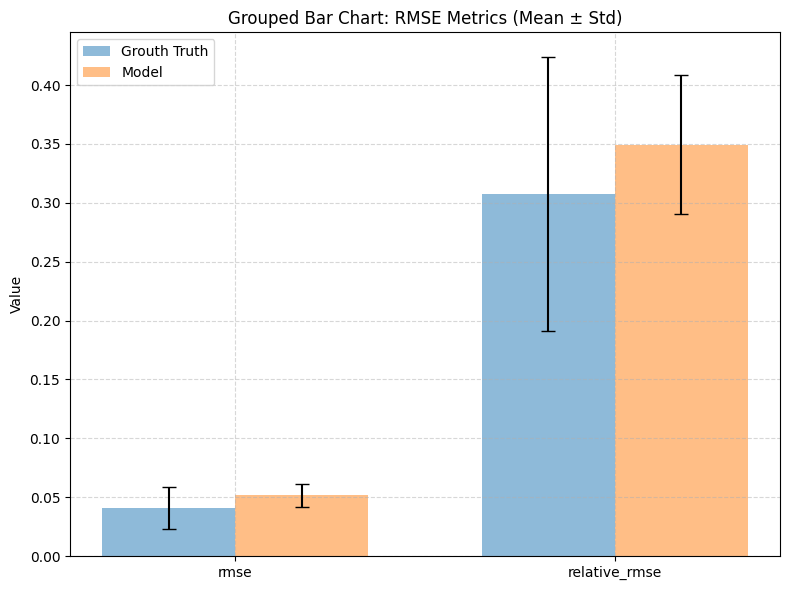

In [75]:
# Convert to DataFrame
df_results = pd.DataFrame(results)

# Compute mean and std
summary_stats = df_results.agg(['mean', 'std']).T
summary_stats.columns = ['mean', 'std']

# Prepare grouped data
metrics = ['rmse', 'relative_rmse']
x = np.arange(len(metrics))  # positions for metric groups
bar_width = 0.35

# Means and stds for each group
true_means = [summary_stats.loc[f'true_{m}', 'mean'] for m in metrics]
model_means = [summary_stats.loc[f'model_{m}', 'mean'] for m in metrics]

true_stds = [summary_stats.loc[f'true_{m}', 'std'] for m in metrics]
model_stds = [summary_stats.loc[f'model_{m}', 'std'] for m in metrics]

# Colors from default matplotlib style
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
true_color = colors[0]   # blue
model_color = colors[1]  # orange

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.bar(x - bar_width/2, true_means, yerr=true_stds, width=bar_width, label='Grouth Truth',
       color=true_color, alpha=0.5, capsize=5)

ax.bar(x + bar_width/2, model_means, yerr=model_stds, width=bar_width, label='Model',
       color=model_color, alpha=0.5, capsize=5)

# Styling
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Value")
ax.set_title("Grouped Bar Chart: RMSE Metrics (Mean ± Std)")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()